# Описание проекта

От добывающей компании "ГлавРосГосНефть" поступил заказ на выбор места для бурения новой скважины. 

Компания обычно выбирает локацию для скважины следующим образом:

- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов
- Строят модель для предсказания объёма запасов в новых скважинах
- Выбирают скважины с самыми высокими оценками значений
- Определяют регион с максимальной суммарной прибылью отобранных скважин

Нам предоставлены пробы нефти в трёх регионах. Характеристики каждой скважины в регионе уже известны. Стоит задача построить модель для определения региона, где добыча принесёт наибольшую прибыль. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import scipy.stats as st

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# Загрузка и первичная предобработка данных

## geo_data_0

Проверим строки на пропуски и дубликаты. 

In [2]:
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    display(geo_data_0.head())
except:
    print('Путь к файлу не найден')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
geo_data_0[geo_data_0.isnull().any(axis=1)]

,id,f0,f1,f2,product


Пропуски в данных отсутствуют.

In [4]:
geo_data_0.duplicated().sum()

0

Явные дубликаты отсутствуют, посмотрим дубликаты в id и в датафрейме без id, чтобы проверить не попались ли некоторые скважины в датасет дважды и нет ли скважин с полностью совпадающими характеристиками.

In [5]:
geo_data_0.drop(['id'], axis=1).duplicated().sum()

0

In [6]:
geo_data_0['id'].duplicated().sum()

10

Некоторые скважины попались в датасет дважды, удалим их.

In [7]:
geo_data_0[geo_data_0['id'].duplicated()]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [8]:
geo_data_0 = geo_data_0[~geo_data_0['id'].duplicated()]

In [9]:
geo_data_0[geo_data_0['id'].duplicated()]

,id,f0,f1,f2,product


Сделаем то же самое для двух других файлов.

## geo_data_1

In [10]:
try:
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    display(geo_data_1.head())
except:
    print('Путь к файлу не найден')

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [11]:
geo_data_1[geo_data_1.isnull().any(axis=1)]

,id,f0,f1,f2,product


In [12]:
geo_data_1.duplicated().sum()

0

In [13]:
geo_data_1['id'].duplicated().sum()

4

In [14]:
geo_data_1[geo_data_1['id'].duplicated()]

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [15]:
geo_data_1 = geo_data_1[~geo_data_1['id'].duplicated()]
geo_data_1[geo_data_1['id'].duplicated()]

,id,f0,f1,f2,product


## geo_data_2

In [16]:
try:
    geo_data_2 = pd.read_csv('geo_data_2.csv')
    display(geo_data_2.head())
except:
    print('Путь к файлу не найден')

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [17]:
geo_data_2[geo_data_2.isnull().any(axis=1)]

,id,f0,f1,f2,product


In [18]:
geo_data_2.duplicated().sum()

0

In [19]:
geo_data_2['id'].duplicated().sum()

4

In [20]:
geo_data_2[geo_data_2['id'].duplicated()]

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


In [21]:
geo_data_2 = geo_data_2[~geo_data_2['id'].duplicated()]
geo_data_2[geo_data_2['id'].duplicated()]

,id,f0,f1,f2,product


## Вывод 

Данные были загружены и предобработаны. Загрузка прошла успешно. Пропуски в данных отсутствуют. Были удалены дубликаты в столбце id во всех датасетах.

# Исследовательский анализ данных

## geo_data_0

In [22]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Посмотрим распределение данных.

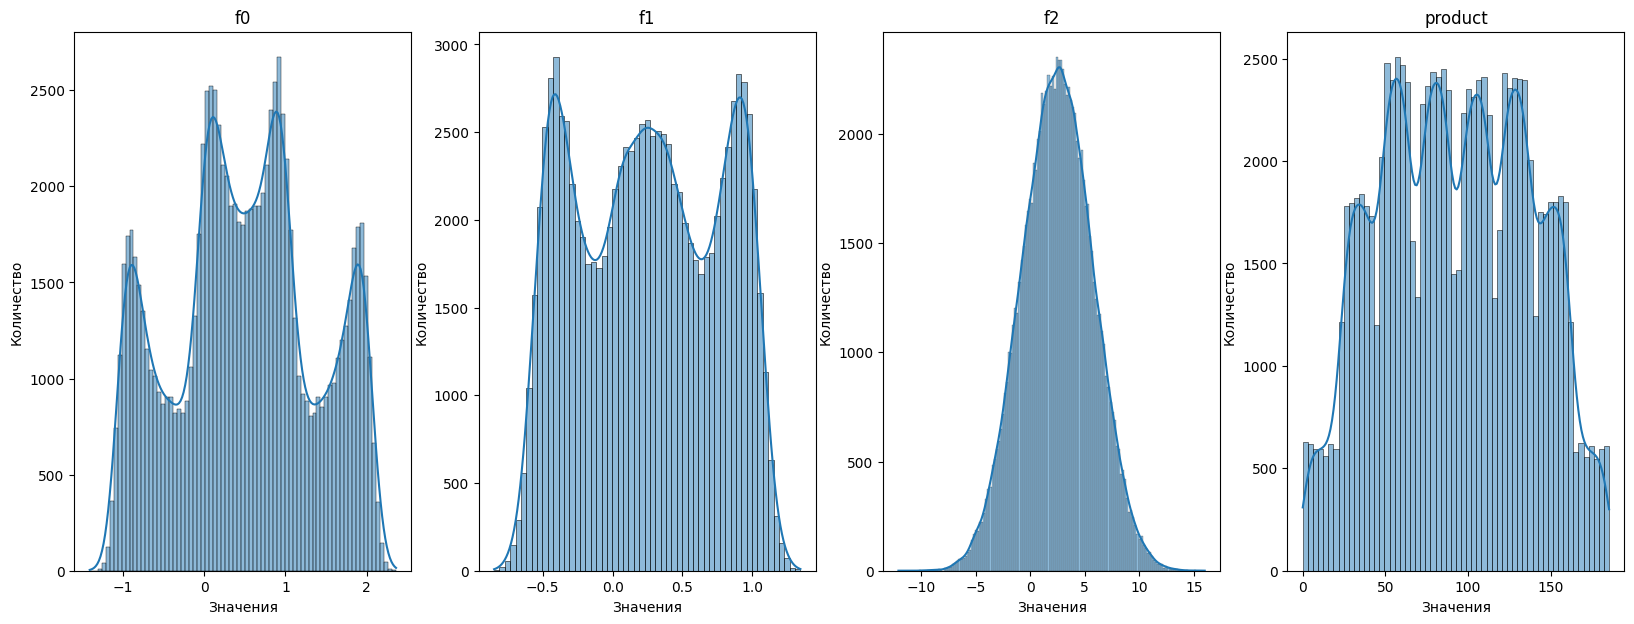

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=len( geo_data_0.select_dtypes(include='number').columns ), figsize=(20,7))

for i, name in enumerate(geo_data_0.select_dtypes(include='number').columns):
    sns.histplot(data=geo_data_0.loc[:, name], ax=axs[i], kde=True)
    axs[i].set_xlabel('Значения')
    axs[i].set_ylabel('Количество')
    axs[i].set_title(name)
plt.show()

Распределение данных только у f2 похоже на нормальное распределение, у остальных распределение не похоже ни на какое из стандартных распределений. 

## geo_data_1

In [24]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


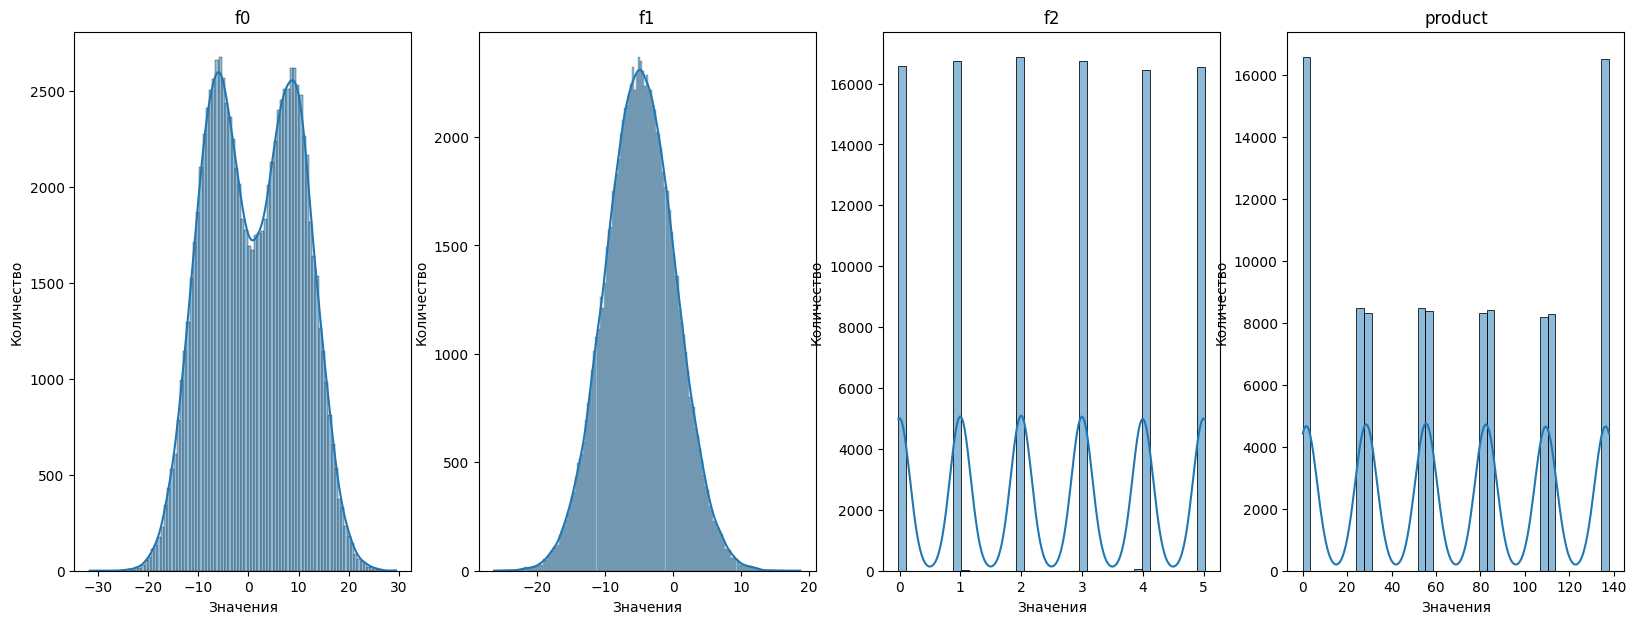

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=len( geo_data_1.select_dtypes(include='number').columns ), figsize=(20,7))

for i, name in enumerate(geo_data_1.select_dtypes(include='number').columns):
    sns.histplot(data=geo_data_1.loc[:, name], ax=axs[i], kde=True)
    axs[i].set_xlabel('Значения')
    axs[i].set_ylabel('Количество')
    axs[i].set_title(name)
plt.show()

f1 имеет близкое к нормальному распределение, f0 похоже на нормальное, но с двумя "колоколами". f2 и product скорее распределены равномерно. Однако, product имеет выбросы в 0 и 140.

## geo_data_2

In [26]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


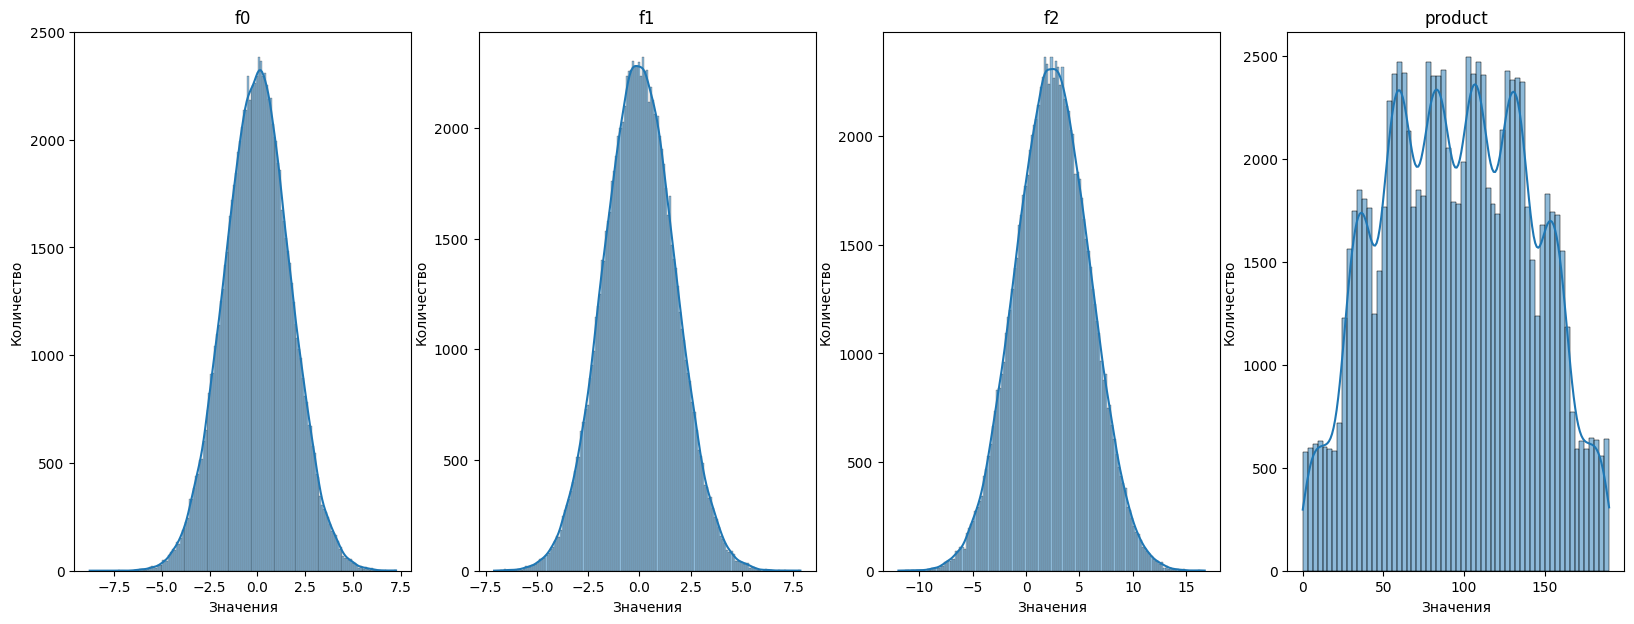

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=len( geo_data_2.select_dtypes(include='number').columns ), figsize=(20,7))

for i, name in enumerate(geo_data_2.select_dtypes(include='number').columns):
    sns.histplot(data=geo_data_2.loc[:, name], ax=axs[i], kde=True)
    axs[i].set_xlabel('Значения')
    axs[i].set_ylabel('Количество')
    axs[i].set_title(name)
plt.show()

В данном случае распределение всех признаков, кроме product, похоже на нормальное распределение. 

## product

Посмотрим распределение product для всех регионов.

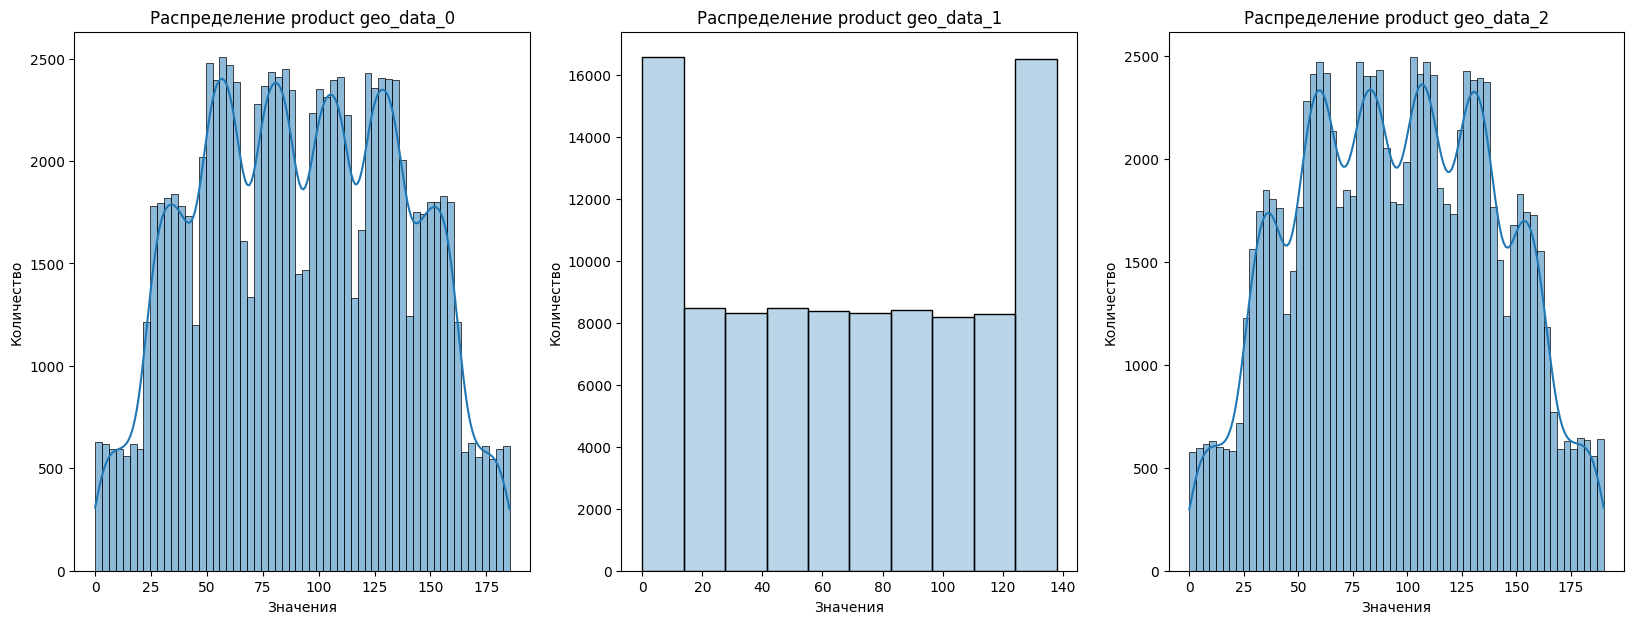

In [28]:
fig, axs = plt.subplots(ncols=3, figsize=(20,7))
datasets = [geo_data_0, geo_data_1, geo_data_2]
for i, data in enumerate(datasets):
    if i != 1:
        sns.histplot(data=data.loc[:, 'product'],  kde=True, ax=axs[i])
    else:
        sns.histplot(data=data.loc[:, 'product'],  kde=False, ax=axs[i], alpha=0.3, bins=10)
    axs[i].set_xlabel('Значения')
    axs[i].set_ylabel('Количество')
    axs[i].set_title(f'Распределение product geo_data_{i}')

Как видим, признак product распределен по-разному во всех трех датасетах. В 0 и 2 они чем-то напоминают нормальное распределение, но с большим количеством колоколов. У geo_data_1 это же равномерное распределение с выбросами в 0 и 140.

# Создание модели

Обучим модель на каждом датасете отдельно, уберем признак id перед обучением, так как он не влияет на предсказание.

In [29]:
def learn_model(data):
    model = LinearRegression()
    data = data.drop(['id'], axis=1)
    X_train, X_val, y_train, y_val = train_test_split(
        data.drop(['product'], axis=1),
        data['product'],
        random_state=RANDOM_STATE
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mean_pred = y_pred.mean()
    rmse = root_mean_squared_error(y_pred, y_val)
    print(f'RMSE: {rmse}, среднее предсказание: {mean_pred}')
    
    return model

models = []
for i in range(3):
    print(f'geo_data_{i}')
    models.append(learn_model(datasets[i].copy()))

geo_data_0
RMSE: 37.68508926201444, среднее предсказание: 92.60984027552017
geo_data_1
RMSE: 0.8928265978121417, среднее предсказание: 68.57703454115173
geo_data_2
RMSE: 40.080822438088305, среднее предсказание: 94.93478722287514


Две из трех моделей вышли плохие, посмотрим корреляционные матрицы. 

In [30]:
for i, data in enumerate(datasets):
    print(f'geo_data_{i}')
    for column in data.select_dtypes(include='number'):
        stat, p_val = shapiro(data[column])
        if p_val < 0.05: 
            print(f'{column} не нормальное')
        else:
            print(f'{column} нормальное')

geo_data_0
f0 не нормальное
f1 не нормальное
f2 не нормальное
product не нормальное
geo_data_1
f0 не нормальное
f1 нормальное
f2 не нормальное
product не нормальное
geo_data_2
f0 нормальное
f1 нормальное
f2 не нормальное
product не нормальное


Распределения частично нормальные, частично нет, поэтому возьём корреляцию Спирмэна.

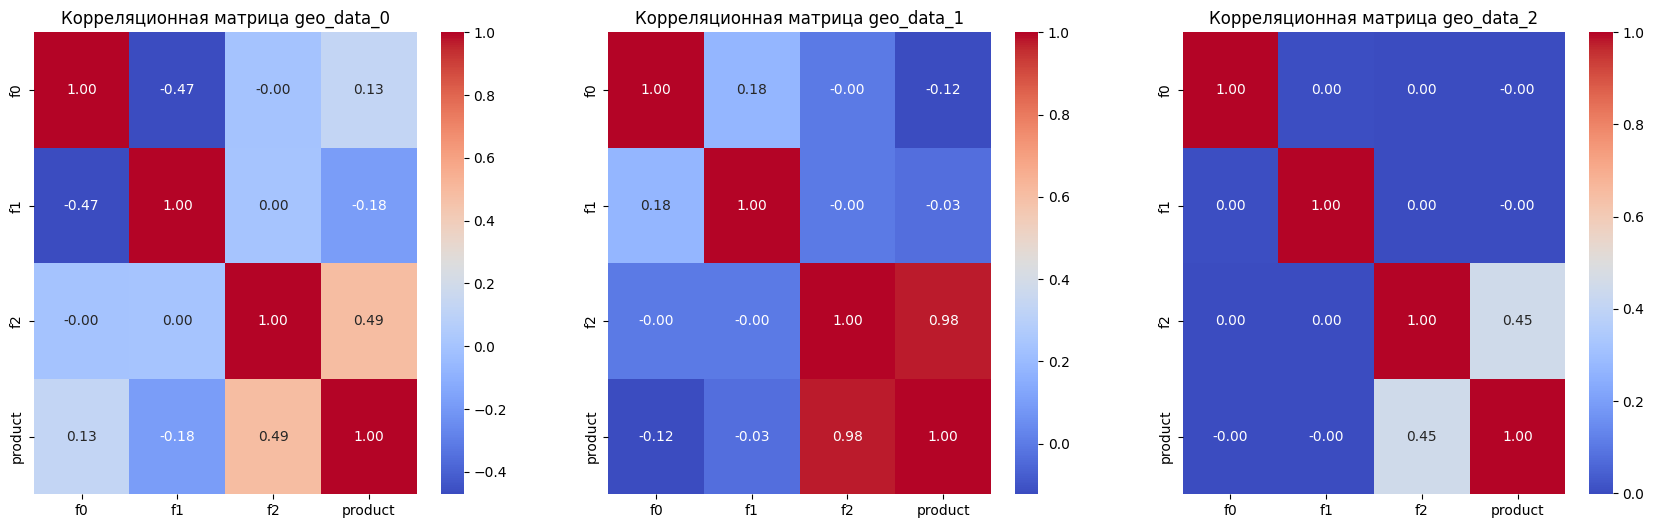

In [31]:
fig, axs = plt.subplots(ncols=3, figsize=(21,6))
for i, data in enumerate(datasets):
    correlation_matrix = data.select_dtypes(include='number').corr(method='spearman')
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axs[i])
    axs[i].set_title(f'Корреляционная матрица geo_data_{i}')

Видно, что модели кроме второй вышли плохие из-за низких корреляций. У второй модели корреляция между f2 и product - 0.98, это много. Остальные не могут похвастаться такой высокой зависимостью между данными, к сожалению. Улучшить модели не выйдет, поэтому будем работать с такими.

Попробуем с помощью пайплайнов подобрать к моделям предобработчик (масштабирование) и SelectKBest, чтобы попробовать улучшить результаты. 

In [32]:
num_columns = geo_data_0.select_dtypes(include='number').columns.drop('product')

data_preprocessor = ColumnTransformer(
    [
        ('scaler', 'passthrough', num_columns)
    ], 
    remainder='passthrough'
)

pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('selector', SelectKBest()),
        ('model', None)
    ]
)

In [33]:
param_grid = {
    'model': [LinearRegression()],
    'preprocessor__scaler': ['passthrough', StandardScaler()],
    'selector__k': range(1, 4)
}

In [34]:
def pipe_model(data):
    data = data.drop(['id'], axis=1)
    X_train, X_val, y_train, y_val = train_test_split(
        data.drop(['product'], axis=1),
        data['product'],
        random_state=RANDOM_STATE
    )
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        refit='neg_root_mean_squared_error'
    )

    grid.fit(X_train, y_train)
    display(grid)
    y_pred = grid.predict(X_val)
    mean_pred = y_pred.mean()
    rmse = root_mean_squared_error(y_pred, y_val)
    print(f'RMSE: {rmse}, среднее предсказание: {mean_pred}')
    
    return grid

grids = []
for i in range(3):
    print(f'geo_data_{i}')
    grids.append(pipe_model(datasets[i].copy()))

geo_data_0


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         'passthrough',
                                                                         Index(['f0', 'f1', 'f2'], dtype='object'))])),
                                       ('selector', SelectKBest()),
                                       ('model', None)]),
             n_jobs=-1,
             param_grid={'model': [LinearRegression()],
                         'preprocessor__scaler': ['passthrough',
                                                  StandardScaler()],
                         'selector__k': range(1, 4)},
             refit='neg_root_mean_squared_error',
             scoring='neg_root_mean_squared_error')

RMSE: 37.68508926201444, среднее предсказание: 92.60984027552017
geo_data_1


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         'passthrough',
                                                                         Index(['f0', 'f1', 'f2'], dtype='object'))])),
                                       ('selector', SelectKBest()),
                                       ('model', None)]),
             n_jobs=-1,
             param_grid={'model': [LinearRegression()],
                         'preprocessor__scaler': ['passthrough',
                                                  StandardScaler()],
                         'selector__k': range(1, 4)},
             refit='neg_root_mean_squared_error',
             scoring='neg_root_mean_squared_error')

RMSE: 0.8928265978121417, среднее предсказание: 68.57703454115173
geo_data_2


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         'passthrough',
                                                                         Index(['f0', 'f1', 'f2'], dtype='object'))])),
                                       ('selector', SelectKBest()),
                                       ('model', None)]),
             n_jobs=-1,
             param_grid={'model': [LinearRegression()],
                         'preprocessor__scaler': ['passthrough',
                                                  StandardScaler()],
                         'selector__k': range(1, 4)},
             refit='neg_root_mean_squared_error',
             scoring='neg_root_mean_squared_error')

RMSE: 40.079890500632146, среднее предсказание: 94.93593832294818


Как видно, метрики практически не улучшились, поэтому оставим стандартные полученные модели.

# Подготовка к расчёту прибыли

In [35]:
wells_number = 500
best_wells = 200
budget = 10e9
unit_income = 450e3
prob_threshold = 0.025

Нужно понять достаточный объем сырья для окупа разработки реагиона. Всего на разработку региона выделяется 10 млрд рублей и выбирается 200 скважин, поэтому нужно, чтобы прибыль с каждой скважины была в среднем budget / best_wells.

In [36]:
budget / best_wells

50000000.0

С каждой скважины для окупа нужно получать 5 000 000 рублей, значит каждая скважина должна содержать 50 000 000 / unit_income тысяч барелей продукта.

In [37]:
(budget / best_wells) / unit_income

111.11111111111111

Выведем средние в каждом регионе.

In [38]:
print(f'Среднее в 0 регионе: {geo_data_0["product"].mean()}')
print(f'Среднее в 1 регионе: {geo_data_1["product"].mean()}')
print(f'Среднее в 2 регионе: {geo_data_2["product"].mean()}')

Среднее в 0 регионе: 92.49968421774354
Среднее в 1 регионе: 68.82391591804064
Среднее в 2 регионе: 94.99834211933378


Одна скважина должна принести в среднем 111 тысяч баррелей, как видим, средние в регионах меньше 111 тысяч.

# Расчёт прибыли

In [44]:
def profit(model, data):
    prediction = model.predict(data.drop(['id', 'product'], axis=1))
    prediction = pd.Series(prediction, index=data['product'].index)
    prediction = prediction.sort_values(ascending=False)
    return np.sum(data['product'][prediction[:best_wells].index] * unit_income)

for i in range(3):
    print(f'Предсказание прибыли в рублях для {i} региона: {profit(models[i], datasets[i]) - budget:.2f}')

Предсказание прибыли в рублях для 0 региона: 3492332479.78
Предсказание прибыли в рублях для 1 региона: 2415086696.68
Предсказание прибыли в рублях для 2 региона: 2591562707.34


Прибыль всех регионов выходит больше 10 миллиардов рублей. Нужно проверить вероятности.

# Расчёт рисков

С помощью бутстрапа создадим 1000 выборок и посмотрим распределение прибыли. Прибыль это чистый доход, то есть их выручки с регоина надо вычесть 10 млрд на его разработку.

In [45]:
def bootstrap(model, data):
    state = np.random.RandomState(42)
    values = []
    sample = data
    for i in range(1000):
        subsample = sample.sample(frac=wells_number/len(data), replace=True, random_state=state)
        values.append(profit(model, subsample) - budget)
    values = pd.Series(values)
    
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())

    count = 0
    for val in values:
        if val < 0:
            count += 1
    
    plt.title('Распределение прибыли')
    values.plot(kind='hist', grid=True, figsize=(8,5))
    plt.xlabel('Прибыль')
    plt.ylabel('Количество')
    plt.show()
    
    print('Средняя прибыль: {:.2f} рублей'.format(values.mean()))
    print('95%-ый доверительный интервал: от {:.2f} рублей до {:.2f} рублей'.format(confidence_interval[0], confidence_interval[1]))
    print('Вероятность убытка: {:.1%}'.format(count/1000))
    return values

geo_data_0


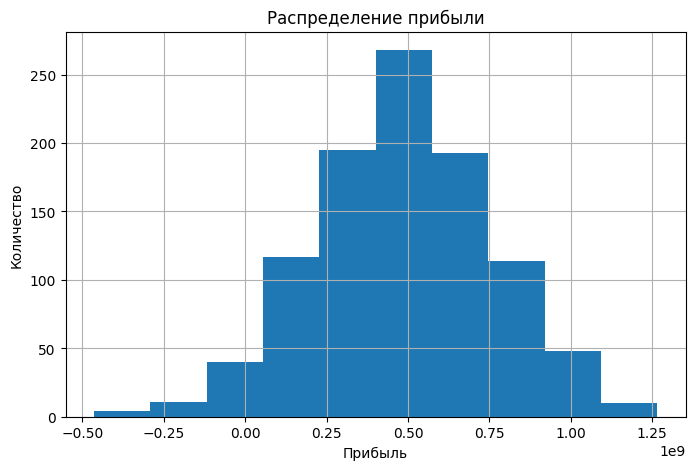

Средняя прибыль: 485273697.52 рублей
95%-ый доверительный интервал: от 468259884.83 рублей до 502287510.21 рублей
Вероятность убытка: 3.3%


In [46]:
print('geo_data_0')
bootstrap(models[0], datasets[0]);

geo_data_1


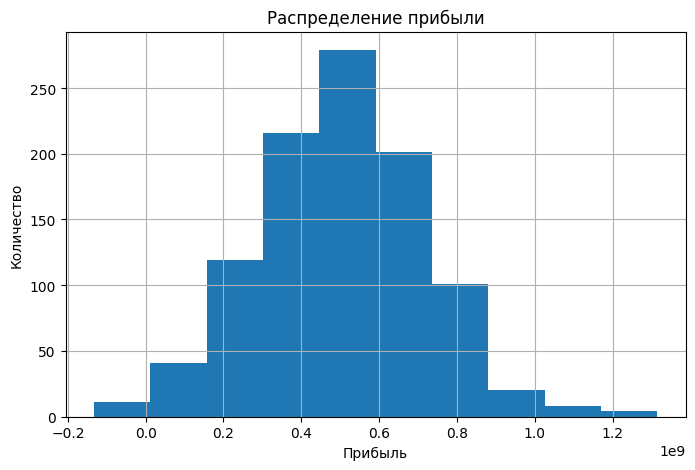

Средняя прибыль: 503448158.43 рублей
95%-ый доверительный интервал: от 490207985.78 рублей до 516688331.08 рублей
Вероятность убытка: 0.9%


In [47]:
print('geo_data_1')
bootstrap(models[1], datasets[1]);

geo_data_2


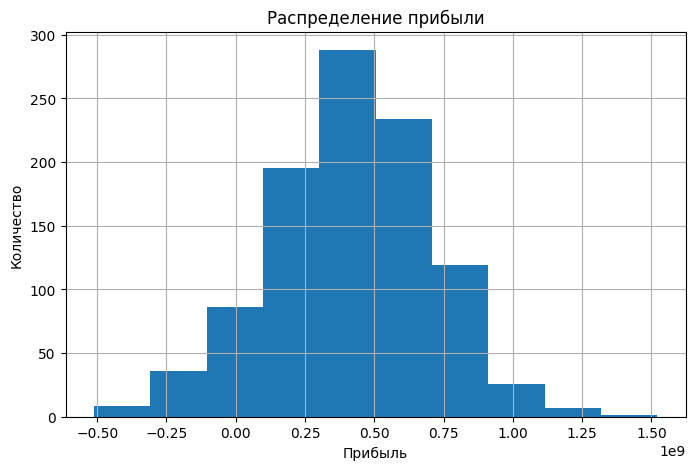

Средняя прибыль: 419629844.94 рублей
95%-ый доверительный интервал: от 401886547.39 рублей до 437373142.49 рублей
Вероятность убытка: 7.8%


In [48]:
print('geo_data_2')
bootstrap(models[2], datasets[2]);

# Вывод

Похоже, что регион geo_data_1 является единственным, где прогнозируемый убыток превышает порог в 2.5%. Средняя прибыль с этого региона составляет 503448158.43 рублей, а вероятность убытка равна 0.9%.

95%-ый доверительный интервал для прибыли из этого региона составляет от 468259884.83 рублей до 502287510.21 рублей. Это довольно узкий диапазон значений, что говорит о сравнительно высокой уверенности в ожидаемых доходах.

Для поиска этого региона были использованы методы бутстрапа и линейной модели. Эти методы помогли провести анализ данных и выявить наиболее выгодный регион для добычи, учитывая потенциальные риски и ожидаемую прибыль.